In [1]:
import sys
sys.path.append('../')
sys.path.append('../model/')
sys.path.append('../model/efficientnet_pytorch/')
# sys.path.append('../input/steelmodel/')
# sys.path.append('../input/steelmodel/model/')
# sys.path.append('../input/steelmodel/model/EfficientNet-PyTorch-master/')
#sys.path.append('../input/efficientnet-pytorch/efficientnet-pytorch/EfficientNet-PyTorch-master/')

import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook
import pickle
import os
import logging
import time
import gc
from IPython.core.debugger import set_trace
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F

from steel_utils import *

#from model_unet import UNetResNet34
from deeplab_model_kaggler.deeplab import DeepLab

#from model_unet_classify_zero import UNetResNet34 as NonzeroClf
from model_unet_classify_zero import predict_proba as predict_proba_nonzero
from efficientnet_pytorch import EfficientNet as NonzeroClf

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(x):
    return np.log(x / (1-x))

%matplotlib inline

In [2]:
######### Config the training process #########
MODEL = 'resnet'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("2,3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = [0,1] #None#[0, 1]#use 2 gpus

#SEED = 1234 #5678#4567#3456#2345#1234
debug = False # if True, load 100 samples
IMG_SIZE = (256,1600) #768#512#256
BATCH_SIZE = 32
NUM_WORKERS = 20


====MODEL ACHITECTURE: resnet====


In [3]:
#net = UNetResNet34(debug=False).cuda(device=device)
#checkpoint_path = '../input/steel-checkpoint/UNetResNet34_256x1600_v1_seed1234.pth.tar'


#checkpoint_path = '../input/steel-checkpoint/deeplabv3plus_resnet_256x1600_v2_seed1234.pth.tar'
#checkpoint_path = '../input/steel-checkpoint/deeplabv3plus_resnet_256x1600_v2_seed2345.pth.tar'

checkpoint_path_list = ['../checkpoint/deeplabv3plus_resnet_256x512_v1_seed1234/best.pth.tar', 
                        '../checkpoint/deeplabv3plus_resnet_256x1600_v2_seed4567/best.pth.tar',
                        '../checkpoint/deeplabv3plus_resnet_256x1600_v2_seed6789/best.pth.tar']
nets = []
for checkpoint_path in checkpoint_path_list:
    net = DeepLab(num_classes=4,
              backbone=MODEL,#resnet34, resnet101
              output_stride=16,#default 16, 8
              sync_bn=None,
              freeze_bn=False,
              debug=False
             ).cuda(device=device)
    
    net, _ = load_checkpoint(checkpoint_path, net)
    print('Loading checkpoint: ', checkpoint_path)
    if multi_gpu is not None:
        net = nn.DataParallel(net, device_ids=multi_gpu)
    
    nets.append(net)

====USE ResNet101====
Loading checkpoint:  ../checkpoint/deeplabv3plus_resnet_256x512_v1_seed1234/best.pth.tar
====USE ResNet101====
Loading checkpoint:  ../checkpoint/deeplabv3plus_resnet_256x1600_v2_seed4567/best.pth.tar
====USE ResNet101====
Loading checkpoint:  ../checkpoint/deeplabv3plus_resnet_256x1600_v2_seed6789/best.pth.tar


In [5]:
## NonzeroClf predict 4-ch-empty and delete mask
#net_clf = NonzeroClf(debug=False).cuda(device=device)
#checkpoint_path = '../input/steel-checkpoint/nonzero_classifier_UNetResNet34_256x1600_v2_seed1234.pth.tar'
#checkpoint_path = '../input/steel-checkpoint/nonzero_classifier_UNetResNet34_256x1600_v2_seed2345.pth.tar'

checkpoint_path_list = [
    '../checkpoint/nonzero_classifier_efficientnet-b3_256x1600_v1_seed1234/best.pth.tar',
    '../checkpoint/nonzero_classifier_efficientnet-b3_256x1600_v1_seed2345/best.pth.tar', 
    '../checkpoint/nonzero_classifier_efficientnet-b3_256x1600_v1_seed3456/best.pth.tar']
net_clfs = []
for checkpoint_path in checkpoint_path_list:
    #net_clf = NonzeroClf(debug=False).cuda(device=device)
    net_clf = NonzeroClf.from_name('efficientnet-b3', override_params={'num_classes': 4}).cuda(device=device)

    net_clf, _ = load_checkpoint(checkpoint_path, net_clf)
    print('Loading checkpoint: ', checkpoint_path)
    if multi_gpu is not None:
        net_clf = nn.DataParallel(net_clf, device_ids=multi_gpu)
    
    net_clfs.append(net_clf)

Loading checkpoint:  ../checkpoint/nonzero_classifier_efficientnet-b3_256x1600_v1_seed1234/best.pth.tar
Loading checkpoint:  ../checkpoint/nonzero_classifier_efficientnet-b3_256x1600_v1_seed2345/best.pth.tar
Loading checkpoint:  ../checkpoint/nonzero_classifier_efficientnet-b3_256x1600_v1_seed3456/best.pth.tar


In [6]:
def predict_mask(logit, logit_clf, CLF_EMPTY_THRESHOLD, EMPTY_THRESHOLD, MASK_THRESHOLD):
    """Transform each prediction into mask.
    input shape: (256, 1600)
    """
    #logit = sigmoid(logit)
    #logit_clf = sigmoid(logit_clf)
    pred = (logit>MASK_THRESHOLD).astype(np.int)
    if pred.sum() < EMPTY_THRESHOLD or logit_clf<CLF_EMPTY_THRESHOLD:
        return np.zeros(pred.shape).astype(np.int)
    else:
        return pred

## predict the testset

In [7]:
EMPTY_THRESHOLD_4ch = [400, 1000, 1100, 1600] #v3: [400, 1000, 1100, 1600] #v2:[400, 1000, 1100, 1600]#v1:[350, 800, 1100, 1500]
CLF_EMPTY_THRESHOLD_4ch = [0.5, 0.5, 0.5, 0.5]#[0.09, 0.1, 0.04, 0.39]
MASK_THRESHOLD = 0.5 #0.48

In [8]:
def predict_proba(net, net_clf, test_dl, EMPTY_THRESHOLD_4ch, CLF_EMPTY_THRESHOLD_4ch, MASK_THRESHOLD, device, multi_gpu=False, mode='test', tta=True):
    """
    step 1: predict proba
    step 2: predict mask & generate rle
    """
    if tta:
        print("use TTA")
    else:
        print("not use TTA")
    
    if len(net)>1:
        for _net in net:            
            if multi_gpu:
                _net.module.set_mode('test')
            else:
                _net.set_mode('test')
    else:
        if multi_gpu:
            net.module.set_mode('test')
        else:
            net.set_mode('test')

    rles = []
    with torch.no_grad():
        for i, image in enumerate(tqdm_notebook(test_dl)):
            input_data = image.to(device=device, dtype=torch.float)
            if tta:#horizontal flip
                input_data_flip = torch.flip(image, [3]).to(device=device, dtype=torch.float)
            
            if len(net)>1:
                logit = 0
                for _net in net:
                    _logit = sigmoid(_net(input_data).cpu().numpy())
                    if tta:
                        _logit_flip = sigmoid(_net(input_data_flip).cpu().numpy()[:,:,:,::-1])
                        _logit = (_logit + _logit_flip) / 2
                    logit += _logit
                logit /= len(net)
            else:
                logit = sigmoid(net(input_data).cpu().numpy())
                logit_flip = sigmoid(net(input_data_flip).cpu().numpy()[:,:,:,::-1])
                logit = (logit + logit_flip) / 2
            
            if len(net_clf)>1:
                logit_clf = 0
                for _net_clf in net_clf:
                    _logit_clf = sigmoid(_net_clf(input_data).cpu().numpy())
                    if tta:
                        _logit_clf_flip = sigmoid(_net_clf(input_data_flip).cpu().numpy())
                        _logit_clf = (_logit_clf + _logit_clf_flip) / 2
                    logit_clf += _logit_clf
                logit_clf /= len(net_clf)
            else:
                logit_clf = sigmoid(net_clf(input_data).cpu().numpy())
                logit_clf_flip = sigmoid(net_clf(input_data_flip).cpu().numpy())
                logit_clf = (logit_clf + logit_clf_flip) / 2
            
            #Generate rle encodings
            for idx_sample in range(logit.shape[0]):
                for ch in range(4):
                    pred_mask = predict_mask(logit[idx_sample][ch], logit_clf[idx_sample][ch], 
                                             CLF_EMPTY_THRESHOLD_4ch[ch], EMPTY_THRESHOLD_4ch[ch], MASK_THRESHOLD)
                    rles.append(mask2rle(pred_mask))
    return rles

In [2]:
test_fnames = [f.split('/')[-1] for f in glob.glob('../data/raw/test/*')]
len(test_fnames), test_fnames[0]

(1801, 'acecbd93a.jpg')

In [10]:
test_dl = prepare_testset(test_fnames, BATCH_SIZE, NUM_WORKERS, IMG_SIZE)

In [11]:
%%time
rles = predict_proba(nets, net_clfs, test_dl, EMPTY_THRESHOLD_4ch, CLF_EMPTY_THRESHOLD_4ch, MASK_THRESHOLD, device, multi_gpu=multi_gpu, mode='test', tta=True)

use TTA



CPU times: user 40min 1s, sys: 3min 11s, total: 43min 13s
Wall time: 5min 55s


In [47]:
## save
with open('../submission/rles.pkl', 'wb') as f:
    pickle.dump(rles, f)

In [4]:
## load
with open('../submission/rles.pkl', 'rb') as f:
    rles = pickle.load(f)

In [5]:
len(rles), np.mean([m!='' for m in rles])

(7204, 0.10591338145474737)

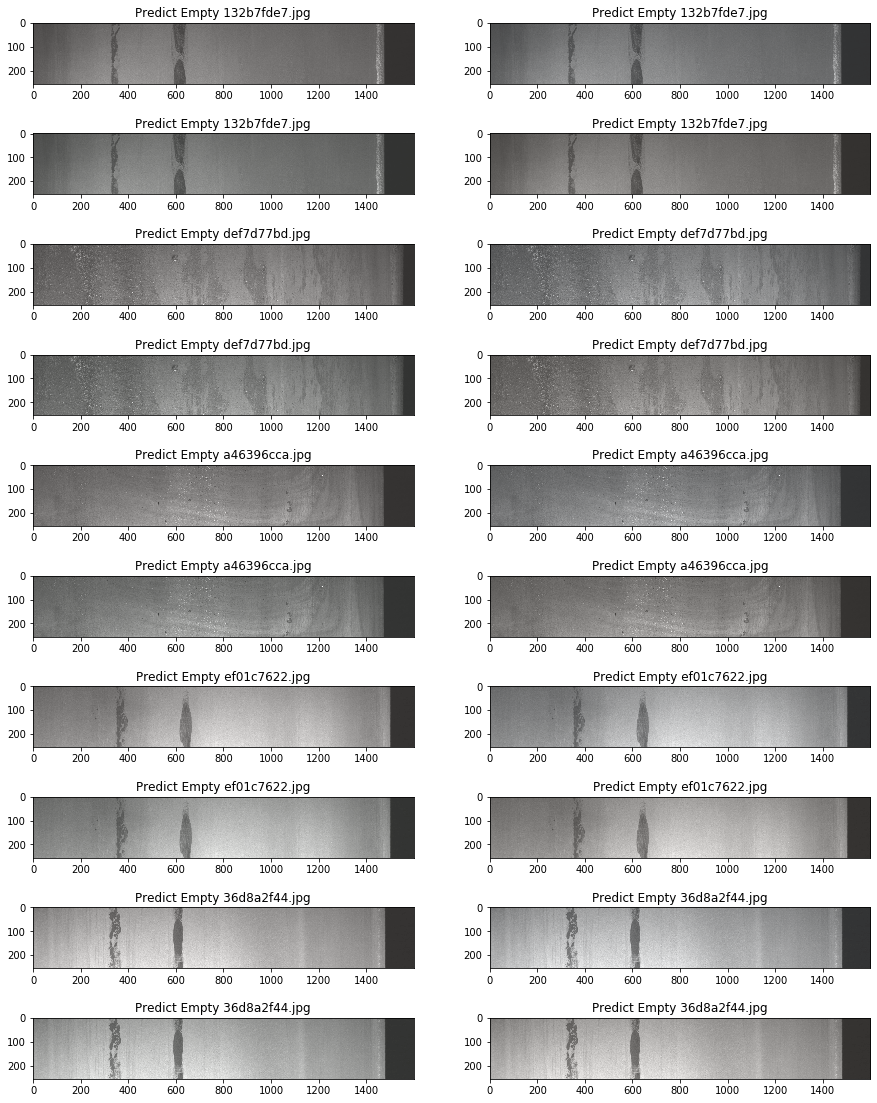

In [6]:
## visualize predicted masks
start = 14

start *= 5
total = 20

cmaps = {0: "Reds", 1: "Blues", 2: "Greens", 3: "Oranges"}

fig=plt.figure(figsize=(15, 20))
cnt = 0
for idx, fname in enumerate(test_fnames):
    if idx<start:
        continue
    img = plt.imread('../data/raw/test/'+fname)[:,:,0]/255
    
    masks_in_rle = rles[idx*4:(idx+1)*4]
    for ch,mask in enumerate(masks_in_rle):
        #if mask=='':
        #    continue
        cnt+=1
        #print(cnt)
        pred_mask = rle2mask(mask)
        ax = fig.add_subplot(10, 2, cnt)
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_mask, alpha=0.2, cmap=cmaps[ch])
        if pred_mask.sum()>0:
            plt.title('Predict (Class=%d) %s'%(ch+1, fname))
        else:
            plt.title('Predict Empty %s'%fname)
        if cnt==total:
            break
    if cnt==total:
        break

## build submission

In [13]:
%%time

img_id_ch = []
for fname in test_fnames:
    for i in range(4):
        img_id_ch.append(fname+'_%d'%(i+1))

sub_df = pd.DataFrame({'ImageId_ClassId': img_id_ch, 'EncodedPixels': rles})
print(len(sub_df.index))
sub_df.head()

7204
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.2 ms


,ImageId_ClassId,EncodedPixels
0,acecbd93a.jpg_1,
1,acecbd93a.jpg_2,
2,acecbd93a.jpg_3,
3,acecbd93a.jpg_4,
4,db9d34c52.jpg_1,


In [42]:
sub_df.to_csv('../submission/submission.csv', index=False)

In [14]:
(sub_df.EncodedPixels!='').mean()

0.10591338145474737

In [30]:
sub_df['has_mask'] = (sub_df.EncodedPixels!='').astype(np.int)
sub_df['cls'] = [img.split('_')[-1] for img in sub_df.ImageId_ClassId]

In [37]:
sub_df.groupby(['cls'])[['has_mask']].agg(['mean', 'sum', 'count'])

has_mask           
         mean  sum count
cls                     
1    0.048862   88  1801
2    0.007773   14  1801
3    0.305386  550  1801
4    0.061632  111  1801

In [39]:
train_df = pd.read_csv('../data/raw/train.csv').fillna('')
train_df.head(5)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,
2,0002cc93b.jpg_3,
3,0002cc93b.jpg_4,
4,00031f466.jpg_1,


In [40]:
train_df['has_mask'] = (train_df.EncodedPixels!='').astype(np.int)
train_df['cls'] = [img.split('_')[-1] for img in train_df.ImageId_ClassId]

In [41]:
train_df.groupby(['cls'])[['has_mask']].agg(['mean', 'sum', 'count'])

has_mask             
         mean   sum  count
cls                       
1    0.071372   897  12568
2    0.019653   247  12568
3    0.409771  5150  12568
4    0.063733   801  12568